In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,          
    mean_absolute_error,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score
)

In [6]:
df = pd.read_csv("Player_Attributes_cleaned_1000.csv", encoding="utf-8")
print(df.head())

features = [
    "potential", "dribbling", "finishing", "short_passing",
    "volleys", "acceleration", "shot_power"
]

X = df[features]
y = df["overall_rating"]


   player_api_id        date  overall_rating  potential preferred_foot  \
0         505942  2016-02-18            67.0       71.0          right   
1         505942  2015-11-19            67.0       71.0          right   
2         505942  2015-09-21            62.0       66.0          right   
3         505942  2015-03-20            61.0       65.0          right   
4         505942  2007-02-22            61.0       65.0          right   

  attacking_work_rate defensive_work_rate  crossing  finishing  \
0              medium              medium      49.0       44.0   
1              medium              medium      49.0       44.0   
2              medium              medium      49.0       44.0   
3              medium              medium      48.0       43.0   
4              medium              medium      48.0       43.0   

   heading_accuracy  ...  vision  penalties  marking  standing_tackle  \
0              71.0  ...    54.0       48.0     65.0             69.0   
1           

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [8]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [9]:
y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"MAE  (Test-Set): {mae:.2f}")
print(f"RMSE (Test-Set): {rmse:.2f}")


MAE  (Test-Set): 0.99
RMSE (Test-Set): 1.73


In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# neg_mean_squared_error → negativ; daher minus nehmen + Wurzel
mse_cv = -cross_val_score(
    rf, X, y,
    cv=kfold,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
rmse_cv = np.sqrt(mse_cv)

print(f"RMSE (5-fold-CV): {rmse_cv.mean():.2f} ± {rmse_cv.std():.2f}")

RMSE (5-fold-CV): 1.50 ± 0.14


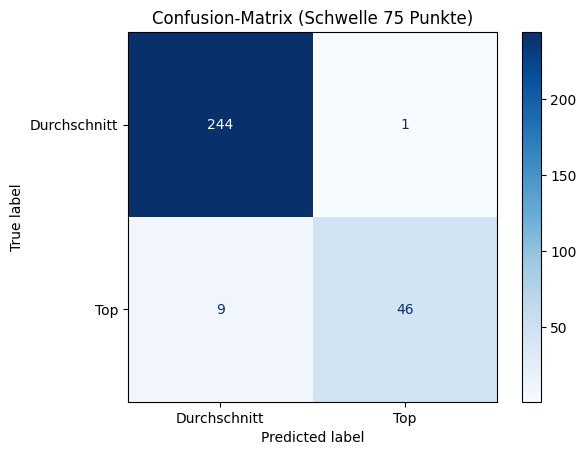

Sensitivität  (Top):         83.64%
Spezifität    (Durchschnitt): 99.59%


In [11]:
threshold = 75
y_true_cls = np.where(y_test >= threshold, 1, 0)
y_pred_cls = np.where(y_pred >= threshold, 1, 0)

cm = confusion_matrix(y_true_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Durchschnitt", "Top"]
)
disp.plot(cmap="Blues")
plt.title("Confusion-Matrix (Schwelle 75 Punkte)")
plt.show()

sensitivity = recall_score(y_true_cls, y_pred_cls, pos_label=1)
specificity = recall_score(y_true_cls, y_pred_cls, pos_label=0)

print(f"Sensitivität  (Top):         {sensitivity:.2%}")
print(f"Spezifität    (Durchschnitt): {specificity:.2%}")

In [12]:
vergleich = pd.DataFrame({
    "Potential":     X_test["potential"].head(10).values,
    "Tatsächlich":   y_test.head(10).values,
    "Vorhergesagt":  y_pred[:10]
})
print("\nStichprobe (erste 10 Zeilen):")
display(vergleich)


Stichprobe (erste 10 Zeilen):


,Potential,Tatsächlich,Vorhergesagt
0,82.0,66.0,68.735000
1,73.0,73.0,69.028333
2,80.0,76.0,69.643250
3,74.0,71.0,70.635000
4,74.0,66.0,65.092333
5,73.0,71.0,70.957935
6,78.0,72.0,71.452226
7,73.0,67.0,66.588333
8,82.0,75.0,75.420000
9,86.0,76.0,77.586667


### Evaluation – Zusammenfassung
Die Testdaten zeigen einen MAE von 0,99 und einen RMSE von 1,73 Punkten.
Die 5-fach-Cross-Validation liefert ein RMSE von (1,5 ± 0,14),
was auf eine stabile Modellleistung hindeutet. Klassifizieren wir Spieler
mit ≥ 75 Punkten als „Top“, erreicht das Modell eine Sensitivität von 83.64 %
und eine Spezifität von 99.59 %. Die Confusion-Matrix bestätigt, dass nur
wenige Durchschnittsspieler fälschlich als Top prognostiziert werden.
Insgesamt liefert der Random-Forest damit sehr präzise und robuste
Vorhersagen für diesen Datensatz.
